In [39]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks',
        color_codes=True, rc={'legend.frameon': False})

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('20210109_dft_ml_redox_data.csv.gz', index_col=0)
df.head()

,smiles,ionization energy,electron affinity,pred ionization energy,pred electron affinity,err ionization energy,err electron affinity
0,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,1.001039,NaN,0.944633,-0.206506,0.056406,NaN
1,C=C(O)C(=S)C1=C([CH]O)C(=O)CCC1=O,0.348169,0.325529,1.196336,-0.039882,0.848167,0.365411
2,C=C(CCO)C1=C([O])CCC=C1CCC,0.964468,-0.281083,1.045361,-0.254922,0.080893,0.026161
3,CCC=C(CN)C(CC)=C([O])C(C)(C)C,0.350509,-0.457001,0.886134,-0.435990,0.535625,0.021011
4,C=C(CCO)C([O])=C(C(C)C)C(C)(C)C,NaN,-0.221001,1.173760,-0.257057,NaN,0.036056


In [4]:
df.shape

(1411, 7)

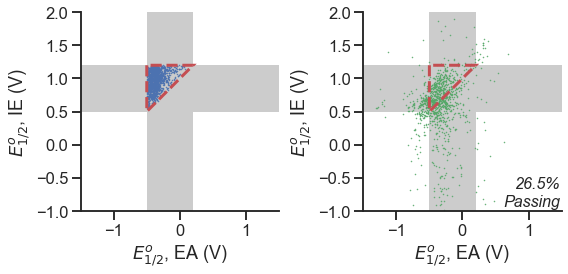

In [5]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=1, rasterized=True)
ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1, 2])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(122, aspect='equal')
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=1, color='g', rasterized=True)
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1, 2])

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df_pass = df[(df['electron affinity'] > -.5) &
        (df['ionization energy'] < 1.2) &
        (df['V_diff'] > 1)]

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='16', style='italic')

sns.despine()
plt.tight_layout()
plt.savefig('redox_dft_confirmation.svg')

In [6]:
df_pass.shape[0] / df.dropna(subset=['V_diff']).shape[0]

0.3475836431226766

In [7]:
df_spin = pd.read_csv('20210109_dft_ml_spin_bv_data.csv.gz')

In [8]:
df_spin.head()

,buried_vol,pred buried_vol,fractional_spin,pred fractional_spin,smiles,atom_index
0,40.057887,37.746520,0.085155,0.130998,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0
1,54.431655,53.257458,0.024316,0.055328,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,1
2,41.549793,40.567318,0.009385,0.004386,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,2
3,32.768445,32.566360,0.001184,0.002064,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,3
4,62.511166,63.582790,0.345404,0.263097,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,4


In [9]:
import rdkit
import rdkit.Chem

In [10]:
def get_atom_symbols():
    for smiles in df_spin.smiles.unique():
        mol = rdkit.Chem.MolFromSmiles(smiles)
        for i, atom in enumerate(mol.GetAtoms()):
            yield pd.Series({
                'smiles': smiles,
                'atom_index': i,
                'atom_symbol': atom.GetSymbol()})

In [11]:
atom_symbol_df = pd.DataFrame(get_atom_symbols())

In [12]:
df_spin_symbol = df_spin.merge(atom_symbol_df, on=['smiles', 'atom_index'])

In [13]:
(df_spin_symbol.groupby('smiles').fractional_spin.idxmax() == df_spin_symbol.groupby('smiles')['pred fractional_spin'].idxmax()).mean()

0.8367491166077738

In [14]:
bur_vol_dft = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x.fractional_spin.idxmax()].buried_vol)
bur_vol_ml = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x['pred fractional_spin'].idxmax()][' pred buried_vol'])

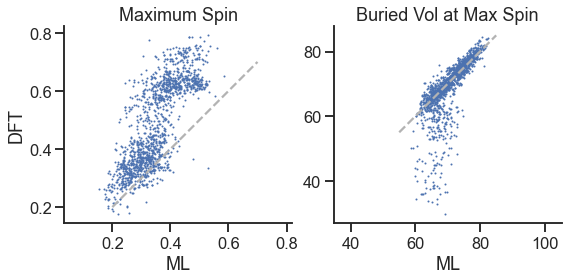

In [15]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal', adjustable='datalim')

ax1.plot(
    df_spin_symbol.groupby('smiles')['pred fractional_spin'].max(),
    df_spin_symbol.groupby('smiles').fractional_spin.max(),
    '.', ms=2)

ax1.plot([.2, .7], [.2, .7], '--', color='.7')

ax2 = fig.add_subplot(122, aspect='equal', adjustable='datalim')
ax2.plot(bur_vol_ml, bur_vol_dft, '.', ms=2)

ax2.plot([55, 85], [55, 85], '--', color='.7')
ax1.set_ylabel('DFT')
ax1.set_xlabel('ML')
ax2.set_xlabel('ML')

ax1.set_title('Maximum Spin')
ax2.set_title('Buried Vol at Max Spin')


sns.despine()
plt.tight_layout()

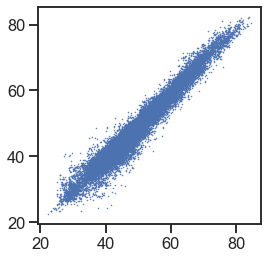

In [16]:
plt.figure(figsize=(4,4))
plt.plot(df_spin_symbol.buried_vol, df_spin_symbol[' pred buried_vol'], '.', ms=1)

In [17]:
df_spin_symbol[df_spin_symbol.smiles == '[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C']

,buried_vol,pred buried_vol,fractional_spin,pred fractional_spin,smiles,atom_index,atom_symbol
2106,44.947879,38.493420,0.000579,0.048509,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,0,C
2107,59.956332,54.700275,0.005813,0.049327,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,1,C
2108,43.212153,36.987812,0.001243,0.002252,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,2,C
2109,70.187789,69.088776,0.172167,0.265295,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,3,C
2110,55.134346,55.942112,0.066513,0.088930,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,4,C
2111,39.170277,38.118496,0.000522,0.002831,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,5,C
2112,47.832913,48.580383,0.100974,0.123389,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,6,C
2113,46.873460,47.651783,0.039578,0.056215,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,7,C
2114,29.608596,29.965496,0.439638,0.199015,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,8,S
2115,54.968019,57.926674,0.106396,0.085428,[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C,9,C


In [18]:
bur_vol_dft.idxmin()

'[CH2]C(C)=C1C(C)=CC(=S)C=C1C(C)(C)C'

In [19]:
x = df_spin_symbol[df_spin_symbol.smiles == 'C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O']

In [20]:
def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    
    score_dft = bur_vol + 50 * (1 - spin)
    
    idxmax = x['pred fractional_spin'].idxmax()
    spin = x['pred fractional_spin'].max()
    bur_vol = x.loc[idxmax][' pred buried_vol']
    
    score_pred = bur_vol + 50 * (1 - spin)
    return pd.Series({'dft': score_dft, 'pred': score_pred})

stability_scores = df_spin_symbol.groupby('smiles').apply(stability_score)

In [21]:
redox_data = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

In [22]:
redf_baseline = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/20210118_bde_baseline_spin_burvol.csv.gz')

def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    return bur_vol + 50 * (1 - spin)

bde_db_stability_scores = redf_baseline.groupby('smiles').apply(stability_score)

,smiles,ionization energy,electron affinity,pred ionization energy,pred electron affinity,err ionization energy,err electron affinity,V_diff,pass_redox
1,C=C(O)C(=S)C1=C([CH]O)C(=O)CCC1=O,0.348169,0.325529,1.196336,-0.039882,0.848167,0.365411,0.022639,False
2,C=C(CCO)C1=C([O])CCC=C1CCC,0.964468,-0.281083,1.045361,-0.254922,0.080893,0.026161,1.245551,True
3,CCC=C(CN)C(CC)=C([O])C(C)(C)C,0.350509,-0.457001,0.886134,-0.435990,0.535625,0.021011,0.807510,False
6,C=C(CCO)C(=C([O])C1CC1)C(C)(C)C,0.801148,-0.479233,1.116788,-0.403732,0.315640,0.075501,1.280381,True
7,CCC=C(COC)C(=C([O])O)C(C)(C)C,0.748060,-0.346688,1.035571,-0.420510,0.287512,0.073821,1.094748,True
...,...,...,...,...,...,...,...,...,...
1390,C=C1CC([O])=C(O)C(CCCC)=C1CC,0.408740,-0.695178,0.899733,-0.413876,0.490993,0.281302,1.103918,False
1391,C=C1CC([O])=C(C)C(C(C)C)=C1C(C)C,0.677828,-0.558280,1.023434,-0.435051,0.345606,0.123230,1.236108,False
1396,CCC1=C(C(C)(C)C)CC(=O)NC1=C[O],0.602781,-0.407641,0.898657,-0.315119,0.295876,0.092522,1.010421,True
1398,CCC1=C(C(C)(C)C)CCC=CC([O])=C1,0.719080,-0.233926,0.894535,-0.377939,0.175455,0.144013,0.953006,False


In [78]:
sns.__version__

'0.10.1'

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/seaborn/distributions.py:690: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


TypeError: _bivariate_kdeplot() got multiple values for argument 'x'

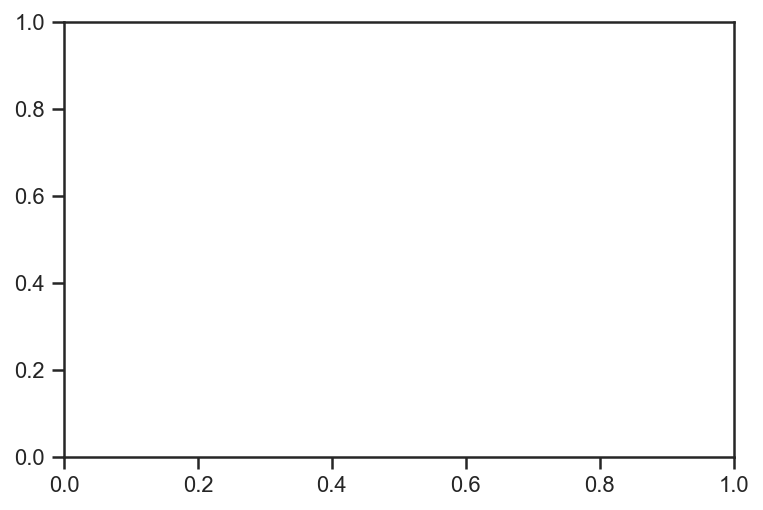

In [77]:
df_nona = df.dropna(subset=['ionization energy', 'electron affinity'])[['ionization energy', 'electron affinity']]
sns.kdeplot(data=df_nona, x='electron affinity', y='ionization energy')

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'fill', 'edgecolor'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


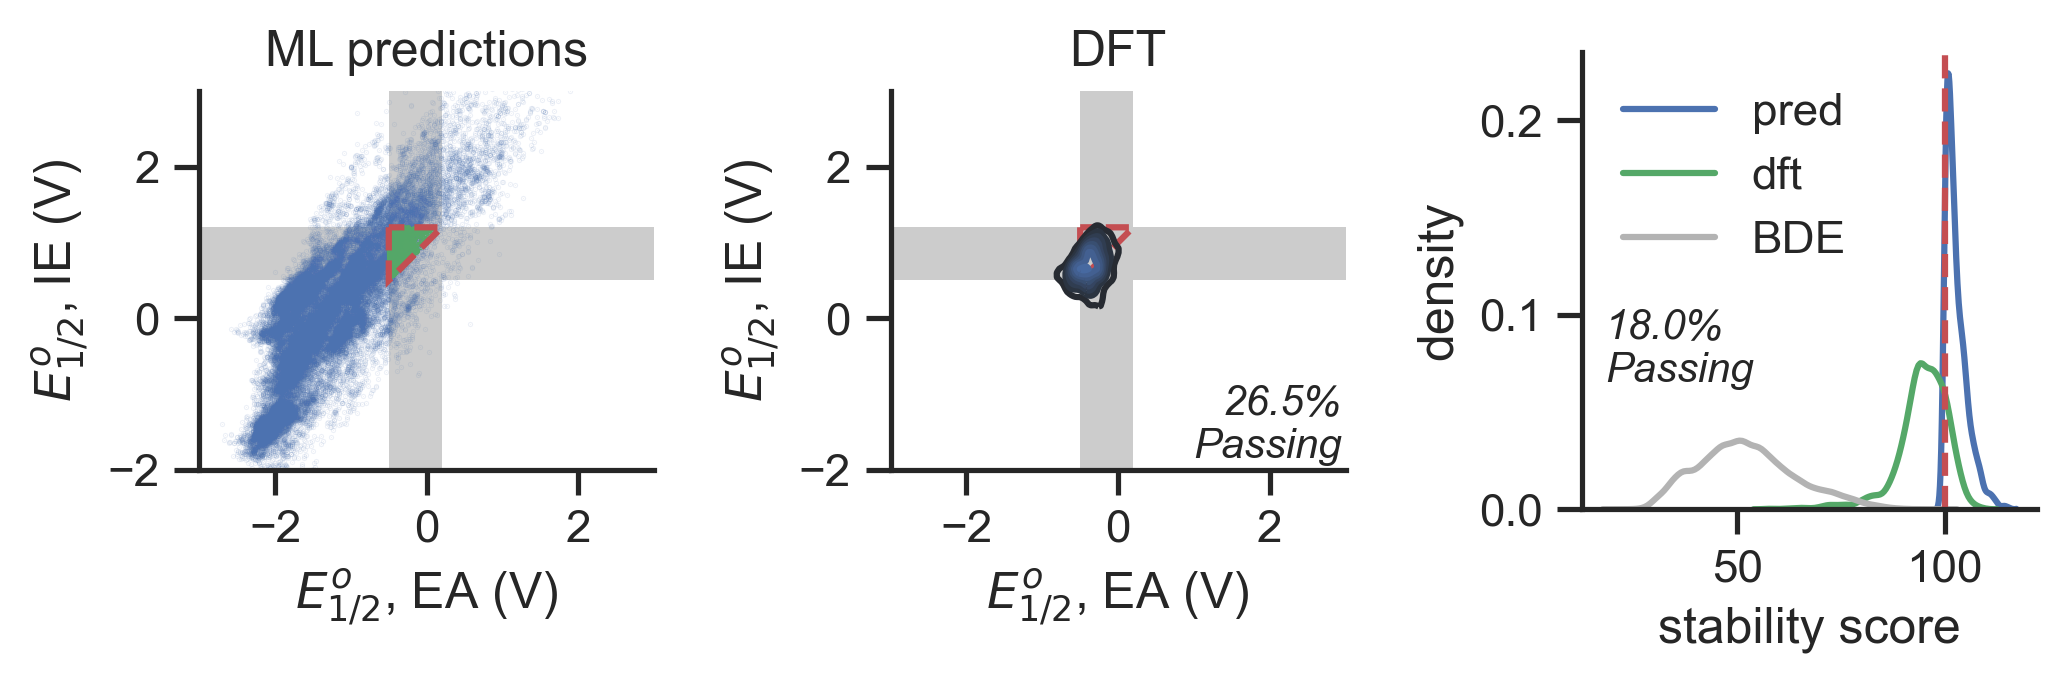

In [73]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(7,2.3), dpi=150)
ax1 = fig.add_subplot(131, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=.5, rasterized=True, color='g', zorder=3)
ax1.plot(redox_data['electron affinity'], redox_data['ionization energy'], '.', ms=.5, rasterized=True, alpha=.1, color='b', zorder=1)

ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=1.5, ls='--'))

ax1.set_xlim([-3, 3])
ax1.set_ylim([-2, 3])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0)
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(132, aspect='equal', sharex=ax1, sharey=ax1)

df_nona = df.dropna(subset=['ionization energy', 'electron affinity'])
sns.kdeplot(df_nona['electron affinity'], df_nona['ionization energy'], ax=ax2, fill=True, edgecolor='none')
# ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=.1, color='g', rasterized=True, zorder=3)
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=1, edgecolor='r', lw=1.5, ls='--'))
# ax2.set_xlim([-1.5, 1.5])
# ax2.set_ylim([-1, 2])

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0)
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df['pass_redox'] = ((df['electron affinity'] > -.5) &
                    (df['ionization energy'] < 1.2) &
                    (df['V_diff'] > 1))
df_pass = df[df.pass_redox]

df_with_stability = df.merge(stability_scores, left_on='smiles', right_index=True)

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='10', style='italic')

ax3 = fig.add_subplot(133)
sns.kdeplot(stability_scores['pred'], color='b')
sns.kdeplot(stability_scores['dft'], color='g')
sns.kdeplot(bde_db_stability_scores, color='.7', label='BDE')

ax3.axvline(100, ls='--', color='r', lw=1.5)
ax3.text(.05, .35, f"{(stability_scores['dft'] > 100).mean():.1%}\nPassing", ha='left', va='center', transform=ax3.transAxes, fontsize='10', style='italic')

plt.ylabel('density')
plt.xlabel('stability score')

ax1.set_title('ML predictions')
ax2.set_title('DFT')

sns.despine()
plt.tight_layout()
# plt.savefig('redox_dft_confirmation.svg')

0.17950530035335688

In [171]:
(df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]).shape[0] / df_with_stability.shape[0]

0.04890148830616584

In [188]:
df_confirmed = df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]

In [191]:
df_confirmed.to_csv('dft_confirmed.csv', index=False)